In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import PchipInterpolator, CubicSpline, Akima1DInterpolator
import mpmath as mp
from scipy.integrate import quad

import sympy as sy
from sympy.abc import x, z, A, B


## General formulas 

In [2]:
L0 = sy.Symbol("L_0")
Z2 = sy.Symbol("Z_2")
T1 = sy.Symbol("T_1")
T2 = sy.Symbol("T_2")

temperature = A*sy.cos(sy.sqrt(L0)*z) + B*sy.sin(sy.sqrt(L0)*z)
temperature



A*cos(sqrt(L_0)*z) + B*sin(sqrt(L_0)*z)

In [3]:
temp_bc = temperature.subs({"A": T1, "B": (T2-T1*sy.cos(sy.sqrt(L0)*Z2))/sy.sin(sy.sqrt(L0)*Z2)})
temp_bc

T_1*cos(sqrt(L_0)*z) + (-T_1*cos(sqrt(L_0)*Z_2) + T_2)*sin(sqrt(L_0)*z)/sin(sqrt(L_0)*Z_2)

In [4]:
WoverI = sy.diff(temp_bc, z).subs({"z":0})
WoverI 

sqrt(L_0)*(-T_1*cos(sqrt(L_0)*Z_2) + T_2)/sin(sqrt(L_0)*Z_2)

In [5]:
WoverI_T2 = sy.diff(temp_bc, z).subs({"z":Z2}).simplify()
WoverI_T2

sqrt(L_0)*(-T_1 + T_2*cos(sqrt(L_0)*Z_2))/sin(sqrt(L_0)*Z_2)

In [6]:
WoverI_prime = sy.simplify(sy.diff(WoverI, Z2))
WoverI_prime

L_0*(T_1 - T_2*cos(sqrt(L_0)*Z_2))/sin(sqrt(L_0)*Z_2)**2

In [7]:
Z2sols = sy.solve(WoverI_prime, Z2)
Z2_opt = Z2sols[1]
Z2_opt

acos(T_1/T_2)/sqrt(L_0)

In [8]:
WoverI_T2.subs({"Z_2":Z2_opt}) # no power absorbed at hot end in the optimized setup!

0

In [9]:
temp_Z2optimized = temp_bc.subs({"Z_2":Z2_opt})
temp_Z2optimized

T_1*cos(sqrt(L_0)*z) + (-T_1**2/T_2 + T_2)*sin(sqrt(L_0)*z)/sqrt(-T_1**2/T_2**2 + 1)

In [10]:
temp_Z2optimized_second = sy.diff(sy.diff(temp_Z2optimized, z), z)
temp_Z2optimized_second

-L_0*T_1*cos(sqrt(L_0)*z) - L_0*(-T_1**2/T_2 + T_2)*sin(sqrt(L_0)*z)/sqrt(-T_1**2/T_2**2 + 1)

In [11]:
Z2opt_calc = sy.lambdify((T1, T2, L0), Z2_opt)
temp_Z2optimized_calc = sy.lambdify((z, T1, T2, L0), temp_Z2optimized)
WoverI_Z2optimized_calc = sy.lambdify((T1,T2,L0), WoverI.subs({"Z_2":Z2_opt}))
WoverI_T2_Z2optimized_calc = sy.lambdify((T1,T2,L0), WoverI_T2.subs({"Z_2":Z2_opt}))
temp_Z2optimized_second_calc = sy.lambdify((z, T1, T2, L0), temp_Z2optimized_second)

### Copper conducibility data

In [12]:
lambda_data = np.loadtxt("../LASA/papers/copper thermal conductivity Powell Roder 1959.txt", unpack=True)
lambda_data[1] *= 100 
lambda_calc = PchipInterpolator(*lambda_data, extrapolate=True)


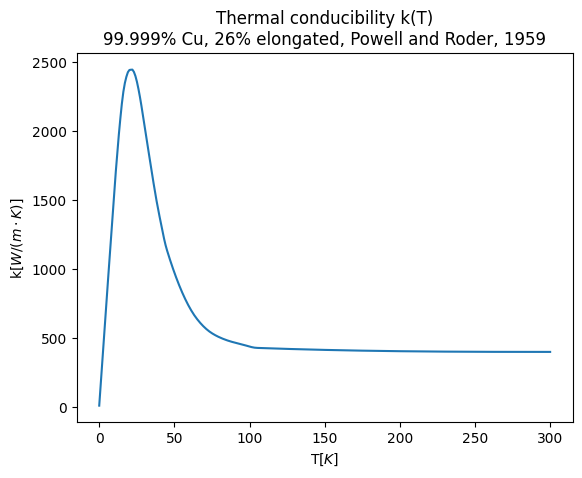

In [13]:
Ts = np.linspace(0, 300, 300)
plt.plot(Ts, lambda_calc(Ts))
_= plt.title("Thermal conducibility k(T)\n" + r"99.999% Cu, 26% elongated, Powell and Roder, 1959")
_= plt.ylabel("k[$W/(m\cdot K)$]")
_= plt.xlabel("T[$K$]")

### Data from MAT PRO (brass)

In [23]:
properties = {1: "specific heat",
2: "electrical resistivity",
3: "thermal conductivity",
4:"density"}

datanames =  ["igrand",  "nfl",  "idir", "rrr", "magnetic field", "temperature", "value"]


conductivity_filename = "../LASA/Programs/brass_conductivity_MATPRO.txt"
resisitivity_filename = "../LASA/Programs/Brass_resistivity_MATPRO.txt"
resistivity_copper_filename = "../LASA/Programs/copper_resistivity_MATPRO.txt"
conductivity_filename_COMSOL = "../LASA/Programs/thermal_conductivity_Cu_RRR100_COMSOL.txt"

def get_Matpro_data(filename):
    with open(filename) as infile:
        for i in range(10): #read maximum 10 lines searching data beginning
            line = infile.readline()
            
            try:
                assert line == " igrand  nfl  idir        rrr   magnetic field  temperature\n"
                data = np.loadtxt(infile, unpack = True)
                break 
            except (AssertionError, IndexError):
                continue
            

    datadict = {name:values for name, values in zip(datanames, data)}
    phyis_property = properties[datadict["igrand"][0]]
    print (phyis_property)
    #print (datadict.keys())
    MATPRO_data = np.array([datadict["temperature"], datadict["value"]])

    return MATPRO_data

def get_COMSOL_data(filename, names=["T", "k"]):

    with open(filename) as infile:
        for i in range(10): #read maximum 10 lines searching data beginning
            line = infile.readline()
            try:
                if line[0] != "%":
                    break
            except IndexError:
                continue
        data = np.loadtxt(infile, unpack = True)
            

    #datadict = {name:values for name, values in zip(names, data)}
    
    COMSOL_data = data #np.array([datadict["temperature"], datadict["value"]])

    return COMSOL_data



MATPRO_brass = get_Matpro_data(conductivity_filename)
MATPRO_brass_resistance = get_Matpro_data(resisitivity_filename)
MATPRO_copper_resistance = get_Matpro_data(resistivity_copper_filename)
COMSOL_copper = get_COMSOL_data(conductivity_filename_COMSOL)



 

thermal conductivity
electrical resistivity
electrical resistivity


## Final formulas for area / length calculations

In [15]:
def IX2overA(T1_, T2_, L0_, Zmax = None, kofT=None):
    if Zmax is None:
        Zmax = Z2opt_calc(T1_, T2_, L0_)
    if kofT is None:
        kofT = lambda_calc
    return quad(lambda z_: kofT(temp_Z2optimized_calc(z_, T1_, T2_, L0_)), 0, Zmax)

def CircleArea(r=None, d=None):
    if r is not None:
        assert d is  None
        return np.pi*r**2
    else:
        assert d is not None
        return np.pi*(d/2)**2
    



## Integrated class for performing all the relevant calculations

In [25]:
from utils import circle

class optimal_ratios_calculator:
    def __init__(self, T1_value, T2_value, L0_value=2.45e-8, data = lambda_data, resdata=None):
        self._T1 = T1_value       
        self._T2 = T2_value
        self._L0 = L0_value
        self._conductivity = PchipInterpolator(*data, extrapolate=True)
        self._data = data 

        if resdata is  not None:
            self._resdata = resdata
            self._resistivity = PchipInterpolator(*resdata, extrapolate=True)
        

    def get_ratios(self, I, x=None, section_args=[], section_kwargs={}):
        
        xOverA = IX2overA(self._T1, self._T2, self._L0, kofT=self._conductivity)[0] / I
        WoverI_value = WoverI_Z2optimized_calc(self._T1, self._T2, self._L0)
        W_value = WoverI_value*I

        self._I = I 

        results = {"W/I":WoverI_value, "W":W_value, "x/A":xOverA}
        
        isgiven = np.array([x is not None, bool(section_args) or bool(section_kwargs)])
        if np.sum(isgiven) > 1:
            print ("Overdetermined system, please only enter either the cable section or its length")
        elif np.sum(isgiven) == 1:
            if isgiven[1]:
                section = circle(*section_args, **section_kwargs)
                x = xOverA*section.A()
            else:
                section = circle(area=x/xOverA) 

            self._section = section

            section.lock()
            results["section"] = section
            results["x"] = x

        return results 
    

    def power_contributions(self, I=None, A=None):
        if I is None:
            I = self._I
        if A is  None:
            A = self._section.A()
        
        thermal_power = I**2/A * quad(lambda z_: temp_Z2optimized_second_calc(z_, self._T1, self._T2, self._L0) /
                                     self._conductivity(temp_Z2optimized_calc(z_, self._T1, self._T2, self._L0)), 0, Z2opt_calc(self._T1, self._T2, self._L0))[0]
        dissipation_power =  I**2/A * quad(lambda z_  : self._resistivity(temp_Z2optimized_calc(z_, self._T1, self._T2, self._L0)), 0, Z2opt_calc(self._T1, self._T2, self._L0))[0]

        return thermal_power, dissipation_power
    

    def temperature_profile(self, show=True, ret = False):
        zs = np.linspace(0, Z2opt_calc(self._T1, self._T2, self._L0))
        Ts = temp_Z2optimized_calc(zs, self._T1, self._T2, self._L0)
        xs = np.array([0] + [IX2overA(self._T1, self._T2, self._L0, z2)[0] for z2 in zs[1:] ]) * self._section.A()/self._I

        _, ax = plt.subplots()
        _=ax.plot(xs*1000, Ts)
        _=ax.set_xlabel("x[mm]")
        _=ax.set_ylabel("T[K]")
        _=ax.set_title("Temperature profile")


        if not show:
            plt.close()
        
        if ret:
            return ax
        
    def plot_conductivity(self, T_range=[], npoints=300): #diagnostic plot of the data used for the thermal conductivity interpolation
        match len(T_range):
            case 0:
                Ts, ks = self._data
            case 2:
                T1_ = np.float64(T_range[0])
                T2_ = np.float64(T_range[1])
                assert T1_<T2_
                Ts = np.linspace(T1_, T2_, npoints)
                ks = self._conductivity(Ts)
            case _:
                raise ValueError("T_range must be either empty (plot source data) or a 2 element list [Tmin, Tmax]")
            
        
        _, ax = plt.subplots()
        _=ax.plot(Ts, ks)
        _=ax.set_xlabel("T[K]")
        _=ax.set_ylabel("k[$W/(m\cdot K)$]")
        _=ax.set_title("Thermal conductivity")

    



                    


### Sample calculation

In [26]:
Z2opt_calc(60, 300, 2.45e-8)

8749.021048071902

I: 500
{'W/I': 0.04630064794363034, 'W': 23.15032397181517, 'x/A': 7663.571821879469, 'x': 2.4075820935874286}
thermal power: (-91132.91853042664, 81367.30634752807)
{'r': 0.01, 'd': 0.02, 'A': 0.0003141592653589793}


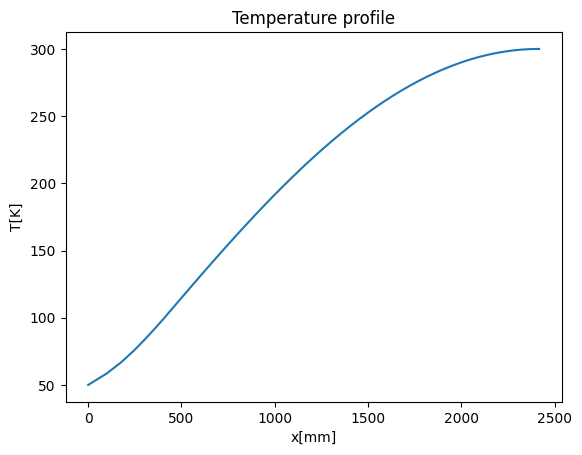

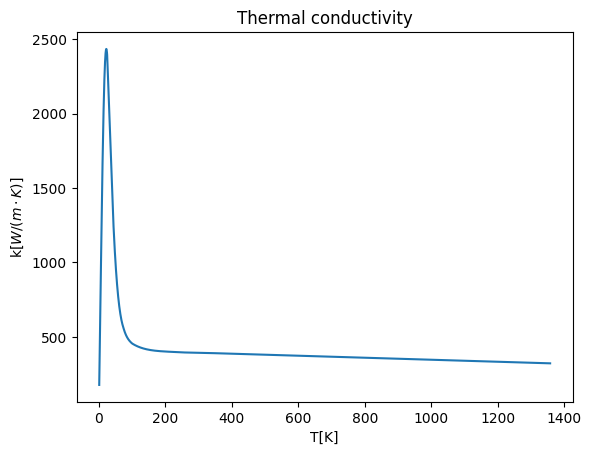

In [28]:
T1_value = 50
T2_value = 300

I = 500

orc = optimal_ratios_calculator(T1_value,T2_value, data=COMSOL_copper, resdata=MATPRO_copper_resistance)

results = orc.get_ratios(I, section_kwargs={"radius":0.01})
sec = results["section"]

thermal_power = orc.power_contributions()

print("I:", I)
print ({key:value for key, value in results.items() if key != "section"})
print ("thermal power:", thermal_power)
print ({key:value for key, value in zip(["r", "d", "A"], [sec.r(), sec.d(), sec.A()])})


orc.temperature_profile()

orc.plot_conductivity()



In [50]:
from scipy.integrate import solve_bvp

L0_value=2.45e-8

copper_res_interp = PchipInterpolator(*MATPRO_copper_resistance)


def Lorenz(T):
    return copper_res_interp(T)*lambda_calc(T)


T1_value = 60
T2_value = 300

Z2_value = 1
grid_size = 100

def differential_callback(z, T):
    return np.array([T[1], -Lorenz(T[0])])

def bc_callback(Ta, Tb):
    return np.array([Ta[0]-T1_value, Tb[0]-T2_value])


zstart = np.linspace(0, Z2_value, grid_size)
Tstart = np.linspace(T1_value, T2_value, grid_size)

Tslope = np.full(Tstart.shape, (T2_value-T1_value)/Z2_value)



result = solve_bvp( differential_callback, bc_callback, zstart, np.array([Tstart, Tslope]))

In [51]:
print(result)

       message: The algorithm converged to the desired accuracy.
       success: True
        status: 0
             x: [ 0.000e+00  1.010e-02 ...  9.899e-01  1.000e+00]
           sol: <scipy.interpolate._interpolate.PPoly object at 0x000002B9925F35B0>
             p: None
             y: [[ 6.000e+01  6.242e+01 ...  2.976e+02  3.000e+02]
                 [ 2.400e+02  2.400e+02 ...  2.400e+02  2.400e+02]]
            yp: [[ 2.400e+02  2.400e+02 ...  2.400e+02  2.400e+02]
                 [-6.696e-07 -7.209e-07 ... -6.567e-06 -6.606e-06]]
 rms_residuals: [ 4.752e-12  1.328e-11 ...  1.854e-12  7.170e-13]
         niter: 1


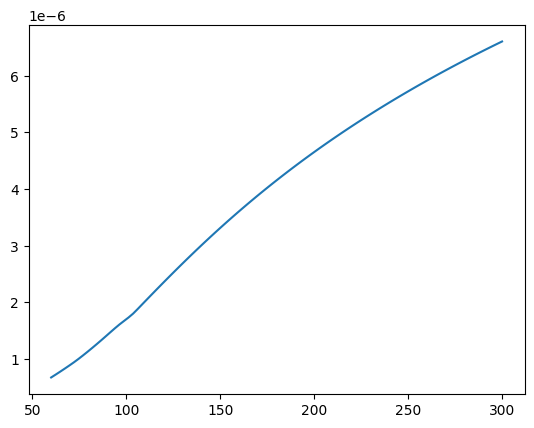

In [52]:
plt.plot(Tstart, Lorenz(Tstart))

In [ ]:
("../LASA/Programs/copper_resistivity_MATPRO.txt")